# Exploratory Data Analysis

In [117]:
#import necessary liabries for data exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

Data has already been split so I will only be working with the train dataset.

In [118]:
#read the train data
train_df = pd.read_csv("../Data/train.csv")
test_df = pd.read_csv("../Data/test.csv")

In [119]:
#view the first ten rows of the data
train_df.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,6
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,7
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,8
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,29.515952,9


In [120]:
#view the last ten rows of the data
train_df.tail(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
75747,6,State_11,Commercial,Grocery_store_or_food_market,58480.0,1980.0,37.0,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,188.519318,75747
75748,6,State_11,Commercial,Commercial_Other,22800.0,1994.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,97.194772,75748
75749,6,State_11,Commercial,Commercial_Other,47237.0,1948.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,126.285151,75749
75750,6,State_11,Commercial,Commercial_Other,72000.0,2013.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,40.525884,75750
75751,6,State_11,Residential,2to4_Unit_Building,28284.0,1928.0,79.0,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,70.298783,75751
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,48.404398,75754
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,592.022750,75755
75756,6,State_11,Residential,2to4_Unit_Building,23888.0,1974.0,51.0,36.6,27,36.935484,...,16,0,0,0,NaN,NaN,NaN,NaN,29.154684,75756


In [121]:
#check the data info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

Looking at the above information, we can see here that we are missing some data.

In [123]:
#let's view the shape of the data
train_df.shape

(75757, 64)

In [124]:
#view the missing values per column in percentage
train_df.isnull().sum() *100 / len(train_df)

Year_Factor                   0.000000
State_Factor                  0.000000
building_class                0.000000
facility_type                 0.000000
floor_area                    0.000000
                               ...    
direction_peak_wind_speed    55.190939
max_wind_speed               54.228652
days_with_fog                60.451179
site_eui                      0.000000
id                            0.000000
Length: 64, dtype: float64

we are missing 55.2% values in direction_peak_wind_speed columns, 54.23% values in max_wind_speed and 60.1% information from the days_with_fog columns.

In [131]:
#check if there is duplicated values
train_df.duplicated().sum()

0

In [132]:
#view the statistical summary of the data
train_df.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,...,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,...,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528601,18939.000000
50%,5.000000,9.136700e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716,37878.000000
75%,6.000000,1.660000e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.277534,56817.000000
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,...,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120,75756.000000


In [133]:
#let's view the columns
train_df.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [134]:
#checking for columns with unique value
train_df[[col for col in train_df.columns if train_df[col].dtype == 'object']].describe()

,State_Factor,building_class,facility_type
count,75757,75757,75757
unique,7,2,60
top,State_6,Residential,Multifamily_Uncategorized
freq,50840,43558,39455


In [135]:
#view the target
train_df['site_eui']

0        248.682615
1         26.500150
2         24.693619
3         48.406926
4          3.899395
            ...    
75752    132.918411
75753     39.483672
75754     48.404398
75755    592.022750
75756     29.154684
Name: site_eui, Length: 75757, dtype: float64

In [90]:
#let us view 
train_df=train_df.drop('id', axis=1)
train_df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395


In [91]:
train_df['site_eui'].describe()

count    75757.000000
mean        82.584693
std         58.255403
min          1.001169
25%         54.528601
50%         75.293716
75%         97.277534
max        997.866120
Name: site_eui, dtype: float64

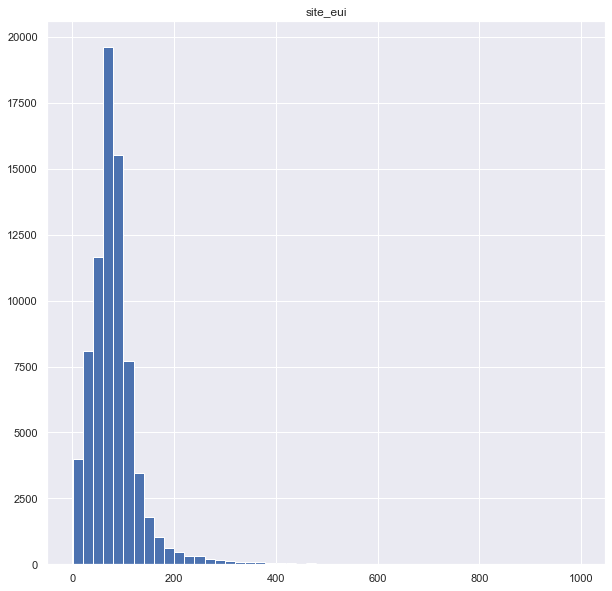

In [136]:
train_df.hist(column='site_eui', bins = 50, figsize=(10,10))
plt.show()

As you can see that the target is positively skewed to the right showing that there are outliers. Let's go ahead and check the boundary values.

In [93]:
#check the boundary values
print("Highest allowed",train_df['site_eui'].mean() + 3 *train_df['site_eui'].std())
print("Lowest allowed",train_df['site_eui'].mean() - 3 *train_df['site_eui'].std())

Highest allowed 257.35090061384864
Lowest allowed -92.18151534140623


Now let's find the outliers

In [109]:
#check for outliers
outliers = train_df[(train_df['site_eui'] > 257.35) | (train_df['site_eui'] > -92.18)]
outliers

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,...,0,14,0,0,0,1.0,1.0,1.0,NaN,189.498654
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,...,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,...,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,...,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,...,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75751,6,State_11,Residential,2to4_Unit_Building,28284.0,1928.0,79.0,63.1,28,43.451613,...,0,25,3,0,0,NaN,NaN,NaN,NaN,70.298783
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,...,0,25,3,0,0,NaN,NaN,NaN,NaN,132.918411
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,...,0,25,3,0,0,NaN,NaN,NaN,NaN,39.483672
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,0,6,0,0,0,NaN,NaN,NaN,NaN,48.404398


Now let's trim off the outliers, cap on it and then apply the capping.

In [110]:
#trimming off the outliers
train_df =train_df[(train_df['site_eui'] < 257.35)&(train_df['site_eui'] > -92.18)]
train_df

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,...,0,14,0,0,0,1.0,1.0,1.0,NaN,189.498654
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,...,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,...,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,...,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,...,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75751,6,State_11,Residential,2to4_Unit_Building,28284.0,1928.0,79.0,63.1,28,43.451613,...,0,25,3,0,0,NaN,NaN,NaN,NaN,70.298783
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,...,0,25,3,0,0,NaN,NaN,NaN,NaN,132.918411
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,...,0,25,3,0,0,NaN,NaN,NaN,NaN,39.483672
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,0,6,0,0,0,NaN,NaN,NaN,NaN,48.404398


In [111]:
#Capping on outliers
upper_limit = train_df['site_eui'].mean() + 3 *train_df['site_eui'].std()
lower_limit = train_df['site_eui'].mean() - 3 *train_df['site_eui'].std()

In [112]:
#Now let's apply the Capping
train_df['site_eui'] = np.where(train_df['site_eui'] > upper_limit,
                               upper_limit,np.where(train_df['site_eui'] < lower_limit,
                                                    lower_limit,train_df['site_eui']))

In [113]:
#view the summary statistics of the target
train_df['site_eui'].describe()

count    74541.000000
mean        77.053955
std         37.126209
min          1.001169
25%         54.086698
50%         74.695355
75%         95.853973
max        188.598254
Name: site_eui, dtype: float64

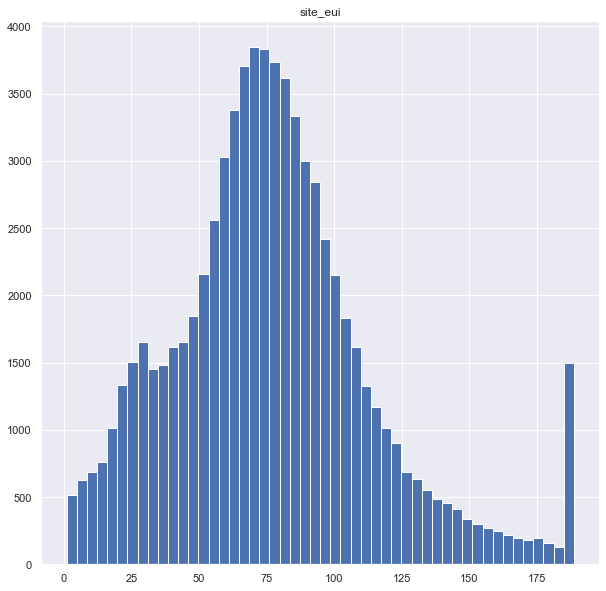

In [114]:
#Now let's plot the histogram again to see if the outlier has been removed.
train_df.hist(column='site_eui', bins = 50, figsize=(10,10))
plt.show()

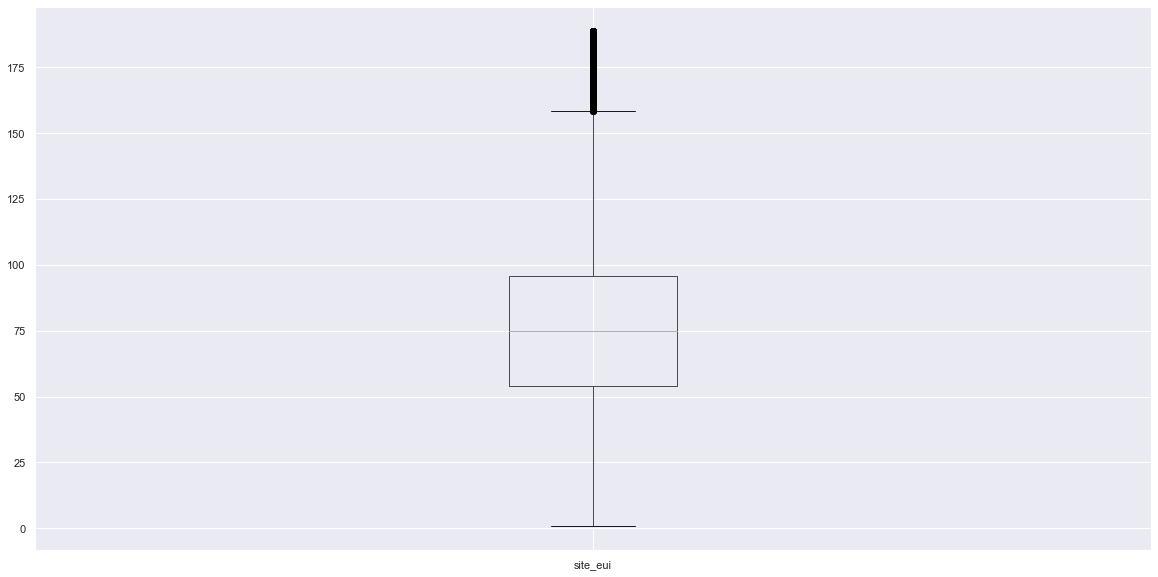

In [115]:
#plot boxplot to view outlier
plt.figure(figsize = (20,10))
train_df.boxplot(column = 'site_eui')
plt.show()

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

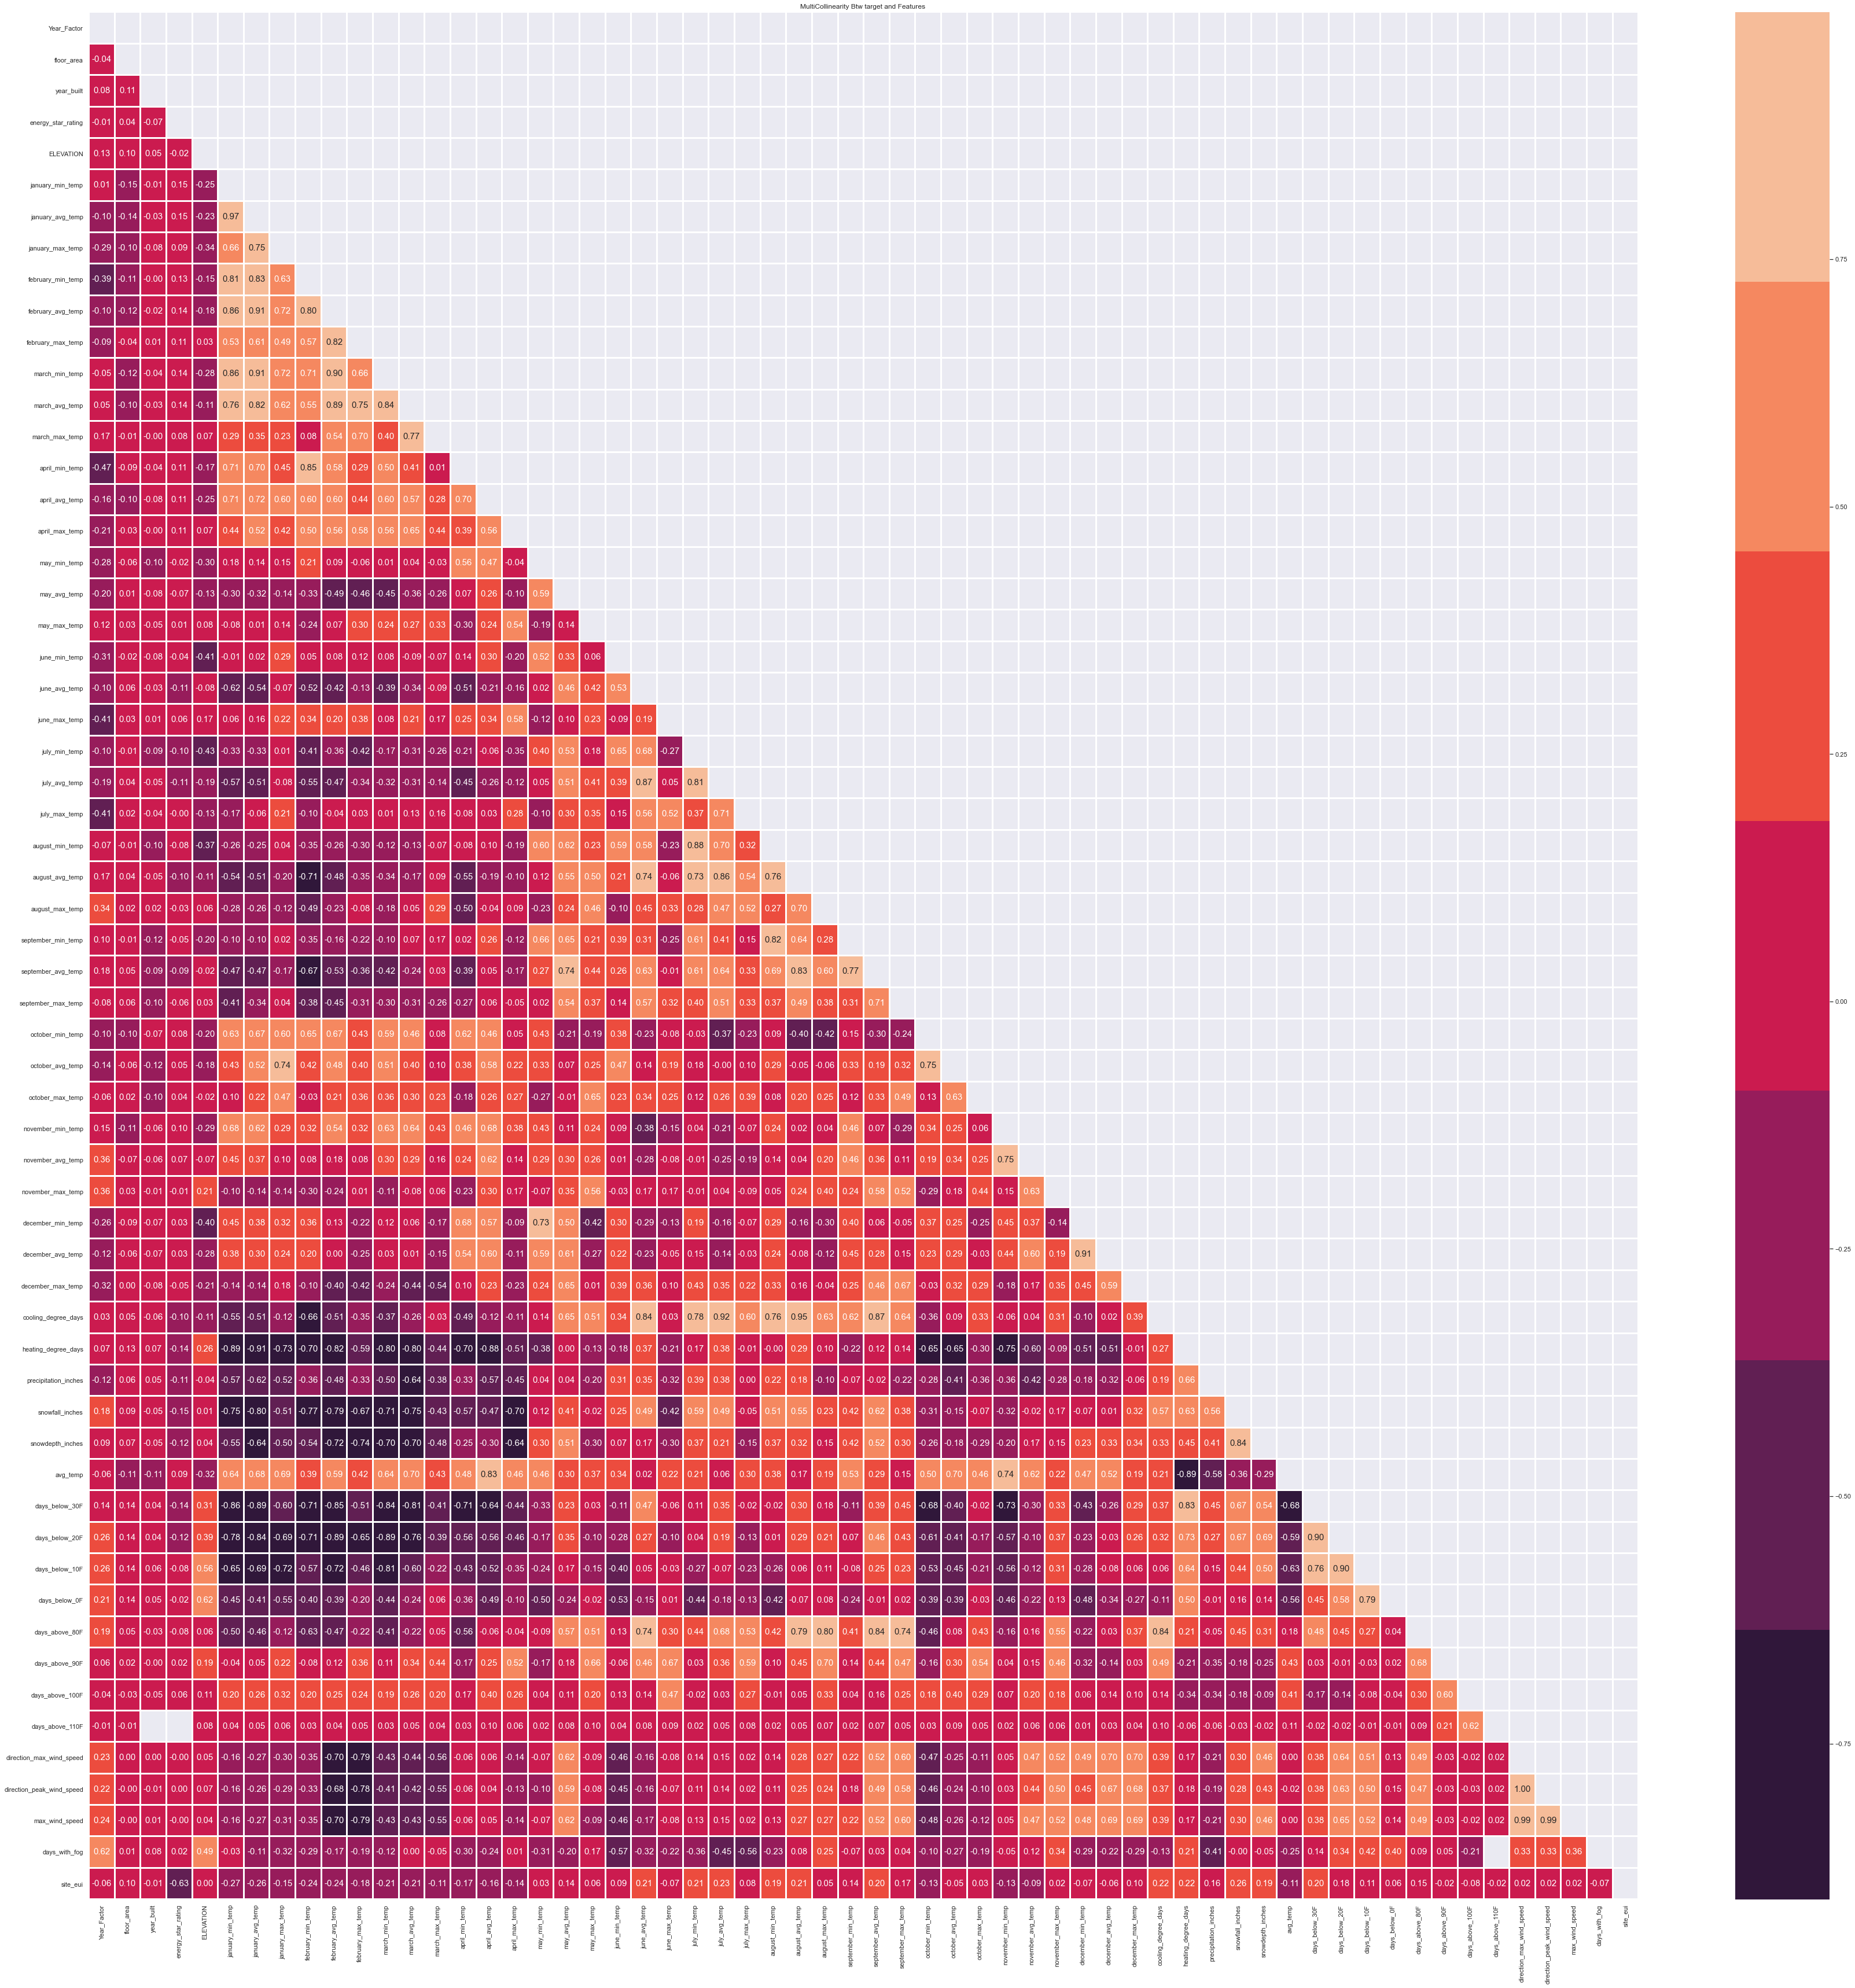

In [116]:
#let's visualize the multicolinearity among the features.
sns.set()
plt.figure(figsize = (60,60))
ax = sns.heatmap(train_df.corr(),mask =np.triu(np.ones_like(train_df.corr(),dtype = bool)), 
            annot = True,cmap =sns.color_palette('rocket',7),
            linewidths=2,linecolor='white',fmt='.2f',annot_kws={"size":15})
plt.title("MultiCollinearity Btw target and Features ")

Text(0.5, 1.0, 'Correlation between the target and features')

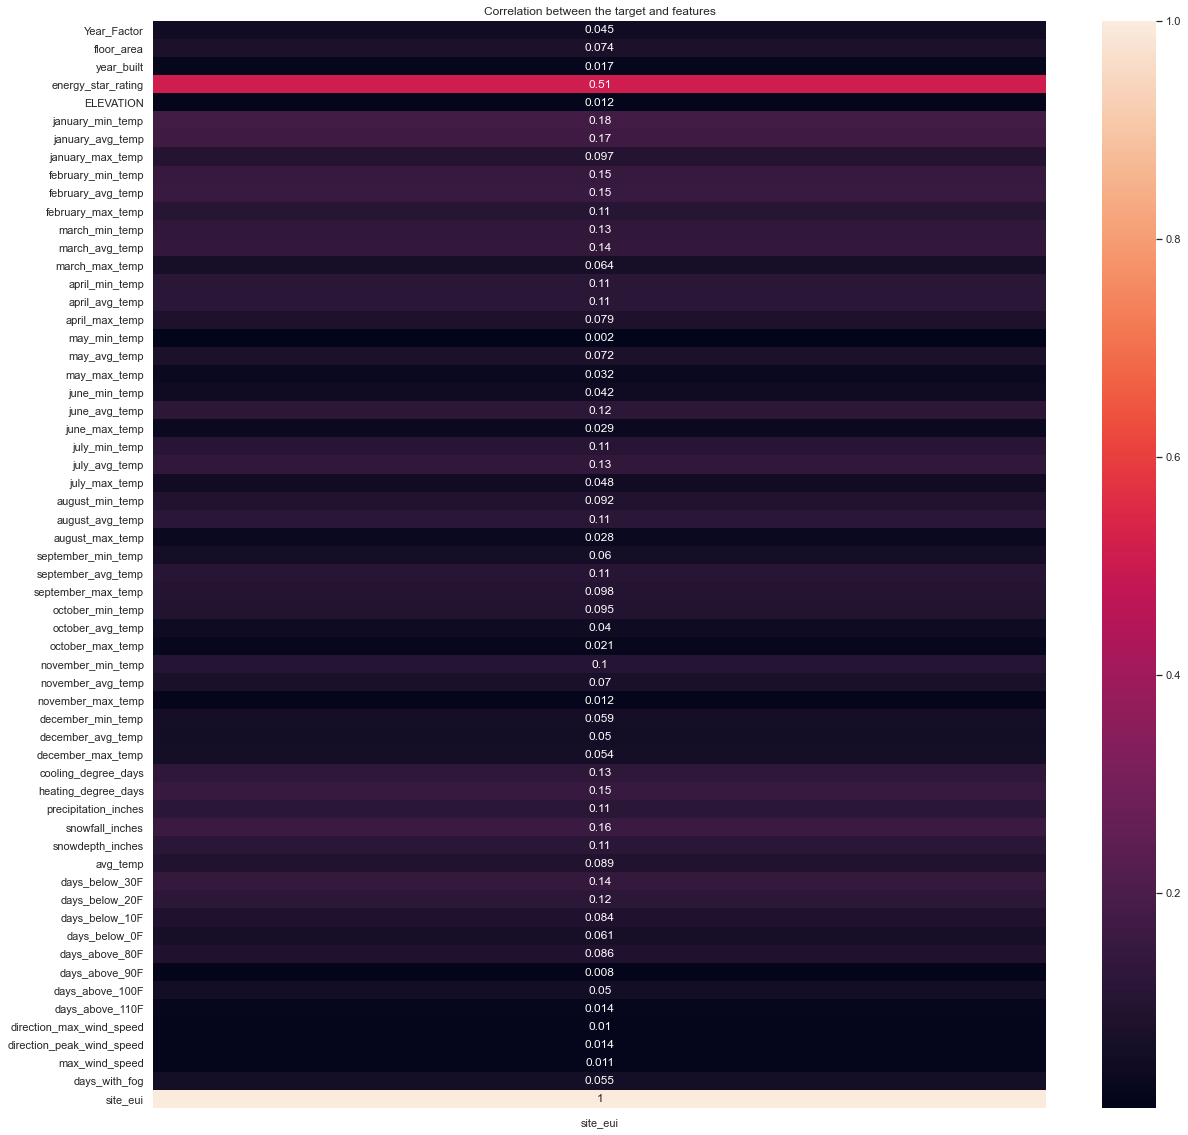

In [25]:
#Using the heatmap to view the feature that correlate with the target.
plt.figure(figsize = (20,20))
ax =sns.heatmap(abs(train_df.corr())[['site_eui']], annot = True);
plt.title("Correlation between the target and features")

In [137]:
#define X and y
X = train_df.drop('site_eui',axis=1)
y= train_df['site_eui']

In [138]:
#view the shape of the data
X.shape, y.shape

((75757, 63), (75757,))

In [141]:
#View the first ten rows of the dependent features
X.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,4
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,5
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,6
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,7
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,8
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,9


In [69]:
#view the first ten rows of the target 
y.head(10)

0    248.682615
1     26.500150
2     24.693619
3     48.406926
4      3.899395
Name: site_eui, dtype: float64

In [142]:
#view the unique values and classify them into it's unique categories
num_cols = []
ohe_cols = []
freq_cols =[]

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        num_cols.append(col)
    elif X[col].nunique() < 10:
        ohe_cols.append(col)
    else:
        freq_cols.append(col)

In [143]:
#print the list of numerical columns,categorical columns and frequency columns
print(f"list of numerical columns: {num_cols}")
print("--")
print(f"list of categorical columns:{ohe_cols}")
print("--")
print(f"list of Frequency columns:{freq_cols}")

list of numerical columns: ['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp', 'february_min_temp', 'february_avg_temp', 'february_max_temp', 'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp', 'august_max_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'october_min_temp', 'october_avg_temp', 'october_max_temp', 'november_min_temp', 'november_avg_temp', 'november_max_temp', 'december_min_temp', 'december_avg_temp', 'december_max_temp', 'cooling_degree_days', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_

In [ ]:
# #Using pipeline to preprocess our data
# #steps
# # scale the numerical columns
# # for the categorical and frequency columns,
# #use the imputer to fill value for null, then oneHotEncode the column

# num_transformer = Pipeline(steps=[
#     ('scaler', MinMaxScaler())
#     ])

# ohe_transformer = Pipeline(steps=[
#     ('ohe_imputer', SimpleImputer(strategy='constant', fill_value= 0,)),
#     ('oh_encoder', OneHotEncoder(drop='first',handle_unknown= 'error'))
# ])

# freq_transformer = Pipeline(steps=[
#     ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
#     ('freq_imputer', SimpleImputer(strategy='constant', fill_value= np.nan))
# ])


# # Package those pieces together using ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, num_cols),
#         ('ohe', ohe_transformer, ohe_cols),
#         ('freq', freq_transformer, freq_cols)
#     ])

# preprocessor.fit(X_train)
